# Universidad de Buenos Aires
# Aprendizaje Profundo - TP1
# Cohorte 20 - 3er bimestre 2025


Este primer TP comienza la semana de la clase 2 y la ventana de entrega estará abierta hasta las **23hs del jueves 31 de julio (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

ESTE TP1 EQUIVALE AL 60% DE SU NOTA FINAL.

El formato de entrega debe ser un link a un notebook de google colab. Permitir acceso a gvilcamiza.ext@fi.uba.ar y **habilitar los comentarios, para poder darles el feedback**. Si no lo hacen así no se podrá dar el feedback respectivo por cada pregunta.

El envío **se realizará en el siguiente link de google forms: [link](https://forms.gle/2UKBgNLjBZZ5XCeH9)**. Tanto los resultados, gráficas, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**NO SE VALIDARÁN ENVÍOS POR CORREO, EL MÉTODO DE ENTREGA ES SOLO POR EL FORMS.**

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP1.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP1-Co20.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.
- Solo se revisarán los trabajos que hayan sido enviados por el forms.

# **PREGUNTA 1**

## **Comparación de Gradiente Descendente y Adam en una Función de Costo No Convexa**

En este ejercicio se compararán los optimizadores Gradiente Descendente (GD) y Adam en la minimización de una función de costo basada en una red neuronal de una sola neurona:
$$
z = w x + b
$$
Con función de activación tangente hiperbólica:

$$
\hat{y} = \tanh(z) = \tanh(w x + b)
$$

\\

Se analizará la trayectoria de aprendizaje de ambos algoritmos y se evaluará su eficiencia con diferentes tasas de aprendizaje (learning rate).

\\

La función de costo utilizada es el Error Cuadrático Medio (MSE):

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2
$$

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} ( \tanh(w x_i + b) - y_i )^2
$$

donde \\( w \\) y \\( b \\) son los parámetros a optimizar.

\\

Si bien es cierto, en estos experimentos estamos comparando optimizadores (GD vs Adam), y no entrenando un modelo como tal, de igual forma se necesitará una especie de dataset. Este será sintético y solo de prueba, por ende tendrán cierta libertad para elegir sus valores. Sin embargo deberán tomar en cuenta que cumpla la siguiente estructura:

`x = np.linspace(ini, fin, n)`

donde `x` es un array de una sola dimensión y con `n` cantidad de valores. Y tiene un rango de valores desde `ini` hasta `fin`. Recomiendo que sea simétrico, es decir, los mismos valores solo que con el signo cambiado, por ejemplo `ini=-3, fin=3`.

\\

Y con un target `y`:

`y = funcion_no_lineal(x) + ruido`

donde `y` es también un vector de una sola dimensión de tamaño `n` que sigue un patrón no lineal con respecto a `x` adicionando un ruido que puede ser creado con algunas de las funciones del paquete `np.random`.


### 1a) Implementación del Gradiente Descendente (1 punto)
- Implementar el algoritmo del Gradiente Descendente (GD) para minimizar \\( J(w, b) \\).
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Inicializar valores de \\( w \\) y \\( b \\) de manera aleatoria con `np.random.randn()` para cada learning rate.
- Graficar la función de Costo \\( J(w, b) \\) VS número de época

\\

El optimizador del Gradiente Descendente se debe implementar haciendo el código desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

In [1]:
from typing import Literal, Optional, Dict, List, Tuple
import numpy as np
from matplotlib import pyplot as plt

SEED = 42

In [2]:
class SimplePerceptron:
    """
    A simple implementation of a single neuron perceptron. With parametrizable
    input and one output. The activation function is the hyperbolic tangent
    function (tanh) by default.
    """
    def __init__(
        self, 
    ):
        """
        Init method for the perceptron.
        """
        np.random.seed(SEED)  # Set seed for reproducibility
        self.weight = np.random.rand(1)
        self.bias = np.random.rand(1)
        
        # Saves the weights and bias for each epoch
        self.w_b: Tuple[List[float], List[float]] = (list(), list())
        self._activation_fun = np.tanh
        self._lr: float = None

    def _reset_weights(self):
        """
        Resets the weights and bias of the perceptron to random values.
        """
        np.random.seed(SEED)
        self.weight = np.random.rand(1)
        self.bias = np.random.rand(1)
        self.w_b = (list(), list())  # Reset the history of weights and bias

    @staticmethod
    def batch_generator(X, y, batch_size=32, shuffle=False):
        n_samples = X.shape[0]
        indices = np.arange(n_samples)

        if shuffle:
            np.random.shuffle(indices)

        for start_idx in range(0, n_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            yield X[batch_indices], y[batch_indices]

    def train(
        self, 
        inputs: np.ndarray, 
        targets: np.ndarray,
        epochs: int,
        lr: float,
        optim: Optional[Literal['adam']] = None,
        batch_size: Optional[int] = None,
        checkpoint: bool = False):
        """
        Trains the perceptron using the provided inputs and targets.

        Parameters
        ----------
        inputs: np.ndarray
            Input data to perform the forward pass.
        targets: np.ndarray
            Target output.
        epochs: int
            Number of epochs.
        lr: float
            Learning rate for the training.
        optim: Optional[Literal['adam']]
            Optimization algorithm to be used. Currently only adam is supported.
            If None, no optimization is applied and the perceptron will use a
            gradient descent update.
        checkpoint: bool
            If True, retrains on top of the wheights and bias of the perceptron.
            If False, the perceptron will be re initialized with random weights
            and bias.
        
        Mutates
        -------
        self.weights: np.ndarray
            Updates the weights of the perceptron.
        self.bias: float
            Updates the bias of the perceptron.
        """
        assert inputs.shape[0] == targets.shape[0], "mismatched input and target sizes"
        
        # mse per epoch
        self.mse = list()

        # Reset weights and bias if not checkpointing
        if not checkpoint:
            self._reset_weights()

        if optim == 'adam':
            r_w, v_w = np.zeros_like(self.weight), np.zeros_like(self.weight)
            r_b, v_b = np.zeros_like(self.bias), np.zeros_like(self.bias)
            p1, p2  = 0.9, 0.999

        _batch_size = len(inputs) if batch_size is None else batch_size
        
        weighs = list()
        bias = list()

        for epoch in range(epochs):

            error = list()
            # create batches
            for x_batch, y_batch in self.batch_generator(
                X=inputs, y=targets, batch_size=_batch_size, shuffle=False):

                # Forward pass
                output = self.predict(inputs=x_batch)

                # Calculate the loss (mean squared error)
                error.append(np.mean(np.power(y_batch - output, 2)).item())
                
                # Derivative of the loss with respect to the output
                grad = -2 * (y_batch - output) * (1 - output ** 2)
                grad_w = np.mean(grad * x_batch)
                grad_b = np.mean(grad)

                if optim is None:
                    # Gradient descent update
                    self.weight -= lr * grad_w
                    self.bias -= lr * grad_b

                elif optim == 'adam':
                    # Momentum update for weights
                    v_w = p1 * v_w + (1 - p1) * grad_w
                    r_w = p2 * r_w + (1 - p2) * (grad_w ** 2)
                    # Momentum update for bias
                    v_b = p1 * v_b + (1 - p1) * grad_b
                    r_b = p2 * r_b + (1 - p2) * (grad_b ** 2)                    
                    self.weight -= lr * v_w / (np.sqrt(r_w) + 1e-8)  # Adding epsilon to avoid division by zero
                    self.bias -= lr * v_b / (np.sqrt(r_b) + 1e-8)
                
            self.mse.append(np.mean(error).item())  # Average loss for the epoch
            weighs.append(self.weight.item())
            bias.append(self.bias.item())
            print(f'Epoch {epoch + 1}/{epochs}, Avg Loss: {self.mse[-1]:.4f}')
        self.w_b = (weighs, bias)

    def predict(self, inputs: np.ndarray) -> List[float]:
        """
        Performs a forward pass through the perceptron.
        
        Parameters
        ----------
        inputs: np.ndarray
            Input data to the perceptron.
        Returns
        -------
        float
            Output of the perceptron after applying the activation function.
        """
        z = self.weight * inputs + self.bias
        return np.tanh(z)

Genero data de entrada y salida

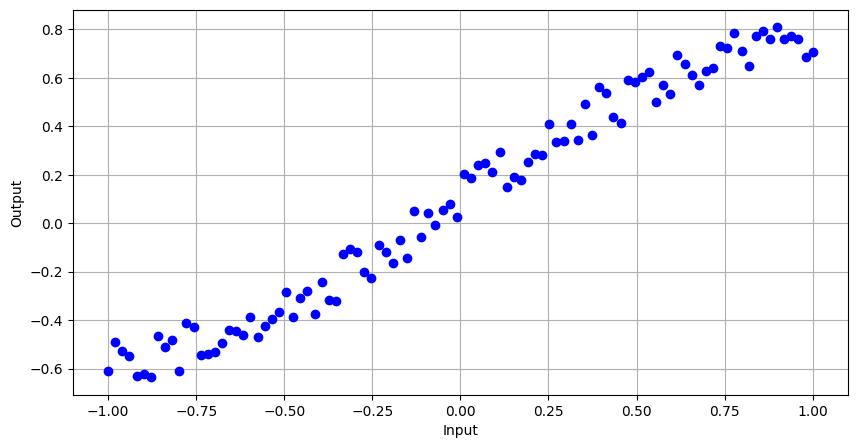

In [3]:
# for reproducibility
np.random.seed(42)

n_samples = 100
input = np.linspace(-1, 1, n_samples)
target = np.tanh(np.sin(input)) + 0.2 * np.random.rand(len(input))

plt.figure(figsize=(10, 5))
plt.plot(input, target, color='blue', marker='o', linestyle='None')
plt.title('Plot of tanh(sin(x))')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('')
plt.grid()
plt.show()


Epoch 1/100, Avg Loss: 0.5321
Epoch 2/100, Avg Loss: 0.4743
Epoch 3/100, Avg Loss: 0.4121
Epoch 4/100, Avg Loss: 0.3479
Epoch 5/100, Avg Loss: 0.2850
Epoch 6/100, Avg Loss: 0.2268
Epoch 7/100, Avg Loss: 0.1761
Epoch 8/100, Avg Loss: 0.1344
Epoch 9/100, Avg Loss: 0.1016
Epoch 10/100, Avg Loss: 0.0767
Epoch 11/100, Avg Loss: 0.0582
Epoch 12/100, Avg Loss: 0.0448
Epoch 13/100, Avg Loss: 0.0350
Epoch 14/100, Avg Loss: 0.0280
Epoch 15/100, Avg Loss: 0.0228
Epoch 16/100, Avg Loss: 0.0191
Epoch 17/100, Avg Loss: 0.0164
Epoch 18/100, Avg Loss: 0.0143
Epoch 19/100, Avg Loss: 0.0128
Epoch 20/100, Avg Loss: 0.0116
Epoch 21/100, Avg Loss: 0.0106
Epoch 22/100, Avg Loss: 0.0099
Epoch 23/100, Avg Loss: 0.0093
Epoch 24/100, Avg Loss: 0.0088
Epoch 25/100, Avg Loss: 0.0084
Epoch 26/100, Avg Loss: 0.0080
Epoch 27/100, Avg Loss: 0.0077
Epoch 28/100, Avg Loss: 0.0075
Epoch 29/100, Avg Loss: 0.0072
Epoch 30/100, Avg Loss: 0.0070
Epoch 31/100, Avg Loss: 0.0068
Epoch 32/100, Avg Loss: 0.0066
Epoch 33/100, Avg

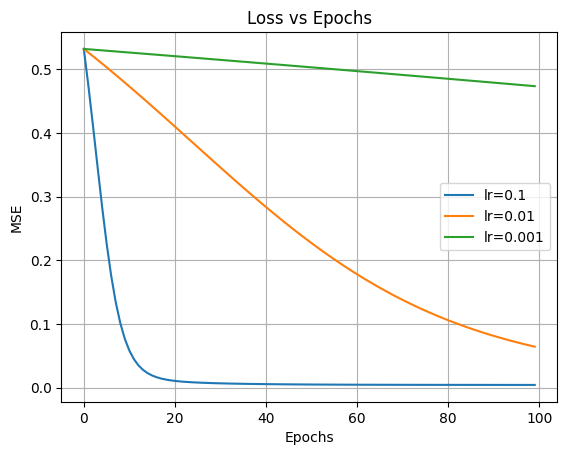

In [4]:
epochs = 100
l_rates = [0.1, 0.01, 0.001]

slp = SimplePerceptron()
preds: Dict[float, List[float]] = dict()
losses_gd: Dict[float, List[float]] = dict()
w_b_gd: Dict[float, Tuple[List[float], List[float]]] = dict()

plt.figure()
for lr in l_rates:
    slp.train(
        inputs=input, targets=target, epochs=epochs, lr=lr, checkpoint=False)
    
    losses_gd[lr] = slp.mse.copy()  # Store the losses for each learning rate
    w_b_gd[lr] = slp.w_b  # Store the weights and bias for each learning rate 
    preds[lr] = slp.predict(inputs=input) # Store the preds for each learning rate
    
    plt.plot(slp.mse, label=f'lr={lr}')
plt.title(f'Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

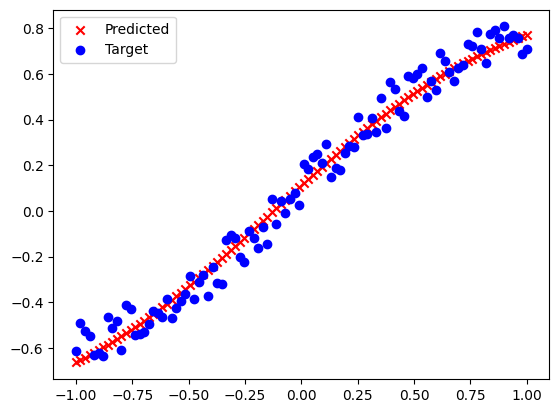

In [5]:
outputs = list()

plt.figure()
plt.scatter(input, preds[0.1], marker='x', color='red')
plt.scatter(input, target, color='blue', marker='o')
plt.legend(['Predicted', 'Target'])
plt.show()

### 1b) Implementación de Adam (1 punto)  
- Implementar el algoritmo de Adam para minimizar \\( J(w, b) \\).  
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Utilizar los mismos valores de \\( w \\) y \\( b \\) que se usaron para GD para cada diferente learning rate.
- Graficar la función de Costo \\( J(w, b) \\) VS número de época
- Hacer 2 modelos, uno sin mini-batch (full-batch) y otro con mini-batch (batch size a elección de ustedes).

\\

Al igual que para GD, el optimizador Adam también se debe implementar desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

Entrenamos usando full batch:

Epoch 1/100, Avg Loss: 0.5321
Epoch 2/100, Avg Loss: 0.2115
Epoch 3/100, Avg Loss: 0.0116
Epoch 4/100, Avg Loss: 0.0760
Epoch 5/100, Avg Loss: 0.1678
Epoch 6/100, Avg Loss: 0.2110
Epoch 7/100, Avg Loss: 0.2143
Epoch 8/100, Avg Loss: 0.1985
Epoch 9/100, Avg Loss: 0.1773
Epoch 10/100, Avg Loss: 0.1573
Epoch 11/100, Avg Loss: 0.1411
Epoch 12/100, Avg Loss: 0.1296
Epoch 13/100, Avg Loss: 0.1230
Epoch 14/100, Avg Loss: 0.1213
Epoch 15/100, Avg Loss: 0.1235
Epoch 16/100, Avg Loss: 0.1276
Epoch 17/100, Avg Loss: 0.1303
Epoch 18/100, Avg Loss: 0.1270
Epoch 19/100, Avg Loss: 0.1136
Epoch 20/100, Avg Loss: 0.0892
Epoch 21/100, Avg Loss: 0.0583
Epoch 22/100, Avg Loss: 0.0296
Epoch 23/100, Avg Loss: 0.0146
Epoch 24/100, Avg Loss: 0.0228
Epoch 25/100, Avg Loss: 0.0465
Epoch 26/100, Avg Loss: 0.0526
Epoch 27/100, Avg Loss: 0.0319
Epoch 28/100, Avg Loss: 0.0164
Epoch 29/100, Avg Loss: 0.0189
Epoch 30/100, Avg Loss: 0.0226
Epoch 31/100, Avg Loss: 0.0206
Epoch 32/100, Avg Loss: 0.0184
Epoch 33/100, Avg

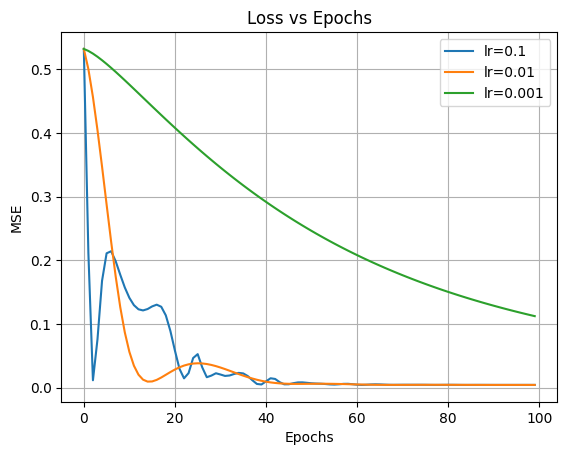

In [6]:
epochs = 100
l_rates = [0.1, 0.01, 0.001]

slp = SimplePerceptron()
losses_adam_fb: Dict[float, List[float]] = dict()
w_b_adam_fb: Dict[float, List[Tuple[float, float]]] = dict()

plt.figure()
for lr in l_rates:
    slp.train(
        inputs=input, 
        targets=target, 
        epochs=epochs, 
        lr=lr,
        checkpoint=False, 
        optim='adam')
    losses_adam_fb[lr] = slp.mse.copy()
    w_b_adam_fb[lr] = slp.w_b

    plt.plot(slp.mse, label=f'lr={lr}')
plt.title(f'Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

Adam con minibatch de N muestras:

Epoch 1/100, Avg Loss: 0.3241
Epoch 2/100, Avg Loss: 0.4287
Epoch 3/100, Avg Loss: 0.3151
Epoch 4/100, Avg Loss: 0.2497
Epoch 5/100, Avg Loss: 0.2232
Epoch 6/100, Avg Loss: 0.2228
Epoch 7/100, Avg Loss: 0.2233
Epoch 8/100, Avg Loss: 0.2189
Epoch 9/100, Avg Loss: 0.2096
Epoch 10/100, Avg Loss: 0.1969
Epoch 11/100, Avg Loss: 0.1821
Epoch 12/100, Avg Loss: 0.1651
Epoch 13/100, Avg Loss: 0.1434
Epoch 14/100, Avg Loss: 0.1123
Epoch 15/100, Avg Loss: 0.0650
Epoch 16/100, Avg Loss: 0.0142
Epoch 17/100, Avg Loss: 0.0298
Epoch 18/100, Avg Loss: 0.0070
Epoch 19/100, Avg Loss: 0.0106
Epoch 20/100, Avg Loss: 0.0106
Epoch 21/100, Avg Loss: 0.0060
Epoch 22/100, Avg Loss: 0.0066
Epoch 23/100, Avg Loss: 0.0043
Epoch 24/100, Avg Loss: 0.0047
Epoch 25/100, Avg Loss: 0.0050
Epoch 26/100, Avg Loss: 0.0047
Epoch 27/100, Avg Loss: 0.0046
Epoch 28/100, Avg Loss: 0.0043
Epoch 29/100, Avg Loss: 0.0044
Epoch 30/100, Avg Loss: 0.0045
Epoch 31/100, Avg Loss: 0.0045
Epoch 32/100, Avg Loss: 0.0044
Epoch 33/100, Avg

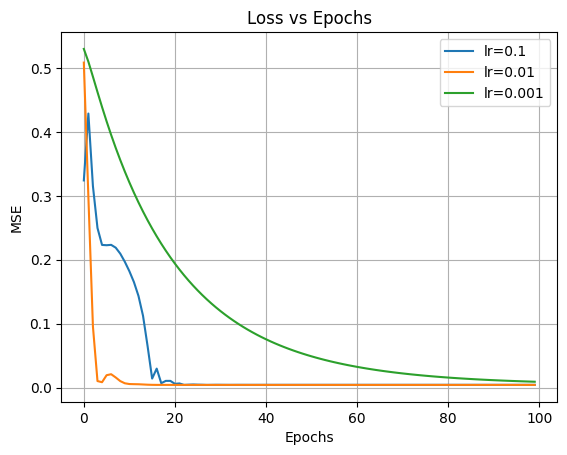

In [7]:
batch_size = 20

losses_adam_mb: Dict[float, List[float]] = dict()
w_b_adam_mb: Dict[float, List[Tuple[float, float]]] = dict()

plt.figure()
for lr in l_rates:
    slp.train(
        inputs=input, 
        targets=target, 
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        checkpoint=False, 
        optim='adam')
    
    # Store the loss for each learning rate
    losses_adam_mb[lr] = slp.mse.copy()
    w_b_adam_mb[lr] = slp.w_b  # Store the weights and bias for each learning rate    

    plt.plot(slp.mse, label=f'lr={lr}')
plt.title(f'Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

### 1c) Comparativa de optimizadores (0.5 puntos)  
- Comparar el resultado y rendimiento de GD VS Adam (full-batch) VS Adam (mini-batch) para cada uno de los learning rates.
- Redactar conclusiones analíticas que resalten las diferencias entre cada optimizador.

Gradient Descent vs Adam (full-batch):

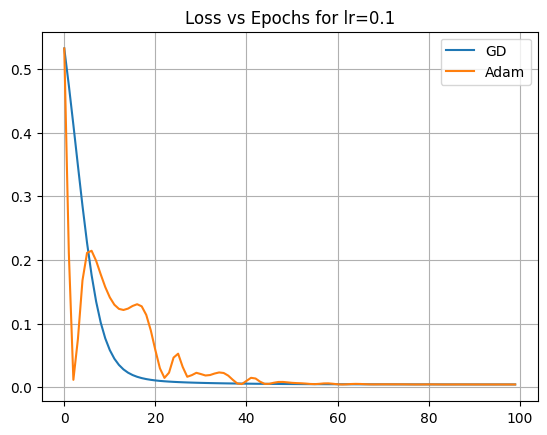

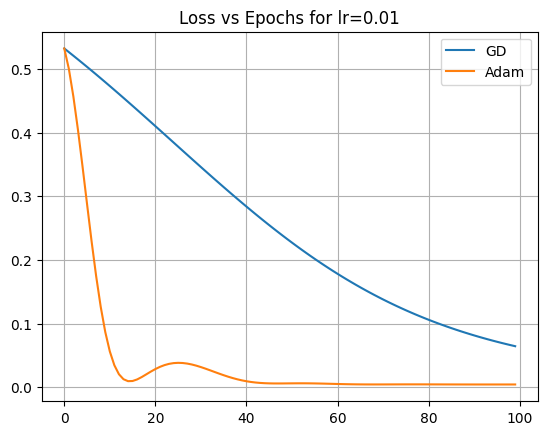

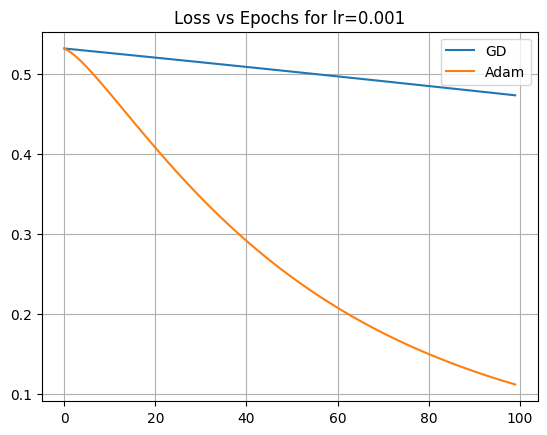

In [8]:
# reutilizamos los curvas de loss obtenidas en los items previos y graficamos
# de a pares:

for lr in l_rates:
    plt.plot(losses_gd[lr], label=f'GD lr={lr}')
    plt.plot(losses_adam_fb[lr], label=f'Adam')
    plt.title(f'Loss vs Epochs for lr={lr}')
    plt.legend(['GD', 'Adam'])
    plt.grid()
    plt.show()
    

Para valores de learning rate de 0.1 y 0.01 no se ven diferencias significativas
en el comportamiento de los optimizadores. Sin embargo, para un learning rate de 0.001, Adam alcanza un mínimo más bajo (para la misma cantidad de epochs) y más rápido que el Gradiente Descendente, lo que indica una mayor eficiencia en la convergencia. 

Gradient Descent vs Adam (mini-batch):

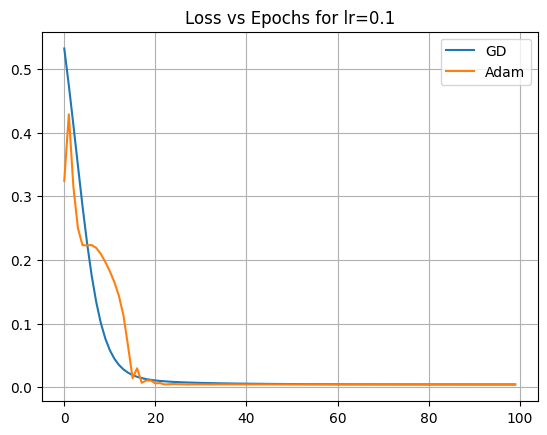

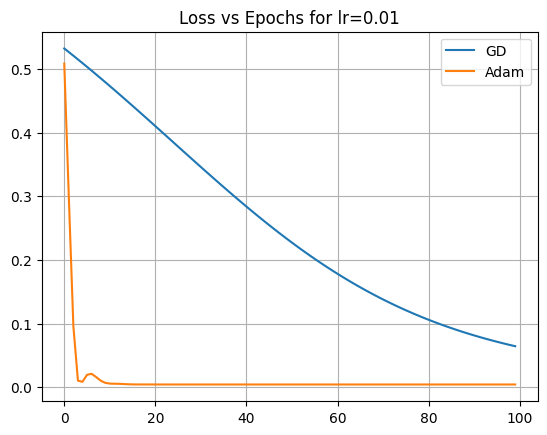

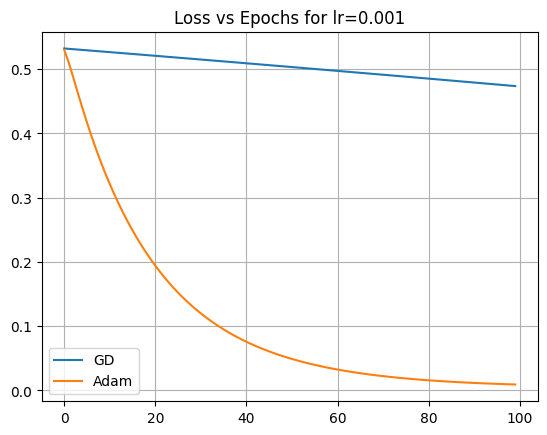

In [9]:
# ajustamos los ejes de los graficos para capturar mejor las diferencias
    
plt.figure()
plt.plot(losses_gd[0.1], label=f'GD lr={lr}')
plt.plot(losses_adam_mb[0.1], label=f'Adam')
plt.title(f'Loss vs Epochs for lr={0.1}')
plt.legend(['GD', 'Adam'])
#plt.ylim(0, 0.01)
#plt.xlim(0, 40)  
plt.grid()
plt.show()

plt.figure()
plt.plot(losses_gd[0.01], label=f'GD lr={lr}')
plt.plot(losses_adam_mb[0.01], label=f'Adam')
plt.title(f'Loss vs Epochs for lr={0.01}')
plt.legend(['GD', 'Adam'])
#plt.ylim(0, 0.02)
#plt.xlim(0, 40)  
plt.grid()
plt.show()

plt.figure()
plt.plot(losses_gd[0.001], label=f'GD lr={lr}')
plt.plot(losses_adam_mb[0.001], label=f'Adam')
plt.title(f'Loss vs Epochs for lr={0.001}')
plt.legend(['GD', 'Adam'])
#plt.ylim(0, 0.01)
# plt.xlim(0, 40)  
plt.grid()
plt.show()

Para el caso del mini-batch, se observa que Adam alcanza una loss mas alta para 
learning rates de 0.1 y 0.01, pero converge más rápido que el Gradiente Descendente. Para un learning rate de 0.001, Adam muestra una convergencia más eficiente que el Gradiente Descendente, alcanzando un mínimo más bajo en menos épocas.

### 1d) Visualización en 3D de la trayectoria de aprendizaje (0.5 puntos)
- Graficar en 3D la trayectoria del aprendizaje de los 3 optimizadores sobre la superficie de la función de costo \\( J(w, b) \\). Se debe elegir un solo learning rate.
- Comparar y redactar cómo se mueven en el espacio de parámetros y qué diferencias existen en la convergencia.
- Recomiendo utilizar `mpl_toolkits.mplot3d` y `np.meshgrid`, pero queda a su criterio la elección de funciones a usar para lograr el gráfico.

In [10]:
from mpl_toolkits.mplot3d import Axes3D

def compute_loss(w, b, X, y):
    y_pred = X * w + b
    return np.mean((y - y_pred) ** 2)

def plot_loss_surface(X, y, w_b, loss_history, title = ''):
    """
    Plots the loss surface for the given weights and bias.
    
    Parameters
    ----------
    X: np.ndarray
        Input data.
    y: np.ndarray
        Target data.
    w_b: Tuple[List[float], List[float]]
        Weights and bias history.
    """
    # create the parameters grid
    weights, bias = w_b

    w_min, w_max = -2 * max(weights), 2 * max(weights)
    b_min, b_max = -2 * max(bias), 2 * max(bias)

    w_vals = np.linspace(w_min, w_max, 100)
    b_vals = np.linspace(b_min, b_max, 100)
    W, B = np.meshgrid(w_vals, b_vals)

    Z = np.array([[compute_loss(w, b, X, y) for w in w_vals] for b in b_vals])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(weights, bias, loss_history, color='red', marker='o', label='Training trajectory', markersize=1)
    # Plot loss surface
    ax.plot_surface(W, B, Z, cmap='viridis', alpha=0.7)
    ax.set_xlabel('Weights')
    ax.set_ylabel('Bias')
    ax.set_zlabel('Loss')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

Como la funcion costo toma valores muy pequeños durante el entrenamiento se grafica solo una porcion de la superficie para que se pueda ver la trayectoria de los optimizadores.

In [12]:
# descomentar para visualizar en ventana externa
%matplotlib qt 

selected_lr = 0.01

for title, wb, losses in zip(
    ['GD', 'Adam (full batch)', 'Adam (mini-batch)'],
    [w_b_gd[selected_lr], w_b_adam_fb[selected_lr], w_b_adam_mb[selected_lr]],
    [losses_gd[selected_lr], losses_adam_fb[selected_lr], losses_adam_mb[selected_lr]]):

    plot_loss_surface(input, target, wb, losses, title=title)

# **PREGUNTA 2**

Descargar el dataset del siguiente link: https://drive.google.com/file/d/147YyKAiQhJhZV9tHAkrgcTzvRgmwB-OX/view?usp=sharing.

El dataset consiste en compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones, compuestas por un cliente y el producto que adquirió.


### 2a) EDA y preparación del dataset (2.5 puntos)
Realizar el análisis exploratorio del dataset (EDA) con las herramientas vistas en materias anteriores. Pre-procesar y transformar las variables que sean necesarias, analizar qué columnas se deben dropear, cuáles vale la pena hacer un tratamiento de valores nulos, si se debe usar label encoding, one-hot encoding o mapping encoding, explicar los criterios utilizados y analizar las distribuciones.

Vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece a un segmento: "Casual" (gasta menos de 3000), "Gama media" (gasta entre 3000 y 8000), "Gama alta" (gasta entre 8000 y 18000) o a "Premium" (gasta más de 18000), según el producto que adquirió.

Redactar las conclusiones preliminares que pueden notar de las columnas y justificar el porqué de cada encoding aplicado.

**IMPORTANTE: Luego de asignar los segmentos, no se olviden de eliminar la columna "Purchase".**

In [79]:
import pandas as pd

DATA_PATH = './dataset_compras.csv'
# Load the dataset
df = pd.read_csv(DATA_PATH)

df.head()

,User_ID,Product_ID,Age,Gender,Marital_Status,City_Category,Stay_In_Current_City_Years,Product_Category,Product_Subcategory_1,Product_Subcategory_2,Purchase
0,1044096,P00017122,46-50,F,1,B,1,10,45.0,NaN,1810
1,1071818,P00074517,36-45,M,0,A,3,11,27.0,NaN,12351
2,1022986,P00013694,36-45,M,1,A,5+,4,28.0,NaN,127
3,1094684,P00049122,36-45,M,1,A,1,16,9.0,8.0,2214
4,1004157,P00006469,46-50,M,1,A,5+,3,NaN,NaN,7142


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182721 entries, 0 to 182720
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     182721 non-null  int64  
 1   Product_ID                  182721 non-null  object 
 2   Age                         182721 non-null  object 
 3   Gender                      182721 non-null  object 
 4   Marital_Status              182721 non-null  int64  
 5   City_Category               182721 non-null  object 
 6   Stay_In_Current_City_Years  182721 non-null  object 
 7   Product_Category            182721 non-null  int64  
 8   Product_Subcategory_1       140903 non-null  float64
 9   Product_Subcategory_2       77461 non-null   float64
 10  Purchase                    182721 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 15.3+ MB


Cantidad de datos faltantes por columna:

In [81]:
print(df.isnull().sum())

User_ID                            0
Product_ID                         0
Age                                0
Gender                             0
Marital_Status                     0
City_Category                      0
Stay_In_Current_City_Years         0
Product_Category                   0
Product_Subcategory_1          41818
Product_Subcategory_2         105260
Purchase                           0
dtype: int64


Filtrado del dataset:

Vemos que el dataset tiene 182721 columnas. La columna `Product_Subcategory_2` contiene 105260 valores nulos, lo que significa que mas del 57% de sus filas tienen datos faltantes. Al tratarse de un identificador de producto no es una informacion que se pueda estimar a partir de datos existentes, por lo tanto, se decide eliminar esta columna. 

Para el caso de la columna `Product_Subcategory_1`, que tiene 41818 valores nulos, se decide eliminarla ya que tambien tienen un 22% de datos faltantes y se espera que el modelo pueda aprender y generalizar a partir de la columna `Product_Category` que no posee datos faltantes.

Se asume que la columna `User_ID` es un identificador aleatorio único de cada usuario y no tendria mucho sentido considerarla para el entrenamiento ya que al realizar clasificacion en datos de produccion, por fuera del dataset, los ids serian diferentes y su valor no tendria relacion con la compra realizada.

In [82]:
df.drop(
    columns=['Product_Subcategory_2', 
             'Product_Subcategory_1', 
             'User_ID',
             'Product_ID'], inplace=True)

In [83]:
# Iterate over columns and print unique values for each
for col in df.columns:
    print(f"{col}: {len(df[col].unique())} unique values")

Age: 7 unique values
Gender: 2 unique values
Marital_Status: 2 unique values
City_Category: 3 unique values
Stay_In_Current_City_Years: 5 unique values
Product_Category: 20 unique values
Purchase: 1833 unique values


Transformamos la columna target `Purchase` en segmentos de clientes, y las columnas `Product_category`, `Gender`, `Stay_In_Current_City_Years`, `City_Category` las transformamos a one-hot encoding.

In [84]:
# Assign segments based on the value of 'Purchase'
def assign_segment(purchase):
    if purchase < 3000:
        return 0
    elif 3000 <= purchase < 8000:
        return 1
    elif 8000 <= purchase < 18000:
        return 3
    else:  # purchase >= 18000
        return 4

target_df = df['Purchase'].apply(assign_segment)
df.drop(columns=['Purchase'], inplace=True)

Aplicamos one-hot encoding a todas las columnas categóricas:


In [85]:
df = pd.get_dummies(df, columns=df.columns, drop_first=True)

# transformo el target
target_df = target_df.to_frame(name='target')
target_df_cat = pd.get_dummies(target_df, columns=target_df.columns, drop_first=True)


In [ ]:
# guardo el dataset con variables categóricas transformadas
df = pd.concat([df, target_df_cat], axis=1)
df.to_csv('dataset_compras_one_hot.csv', index=False)
df.head()

,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Gender_M,Marital_Status_1,City_Category_B,City_Category_C,...,Product_Category_14,Product_Category_15,Product_Category_16,Product_Category_17,Product_Category_18,Product_Category_19,Product_Category_20,target_1,target_3,target_4
0,False,False,False,True,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,True,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,True,True,False,False,...,False,False,True,False,False,False,False,False,False,False
4,False,False,False,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,True,False,False


### 2b) Modelo de deep leaning sin embeddings (1.5 puntos)
Entrenar un modelo de deep learning usando Pytorch que no utilice embeddings, **descartando el `product_id` y `user_id`**. Graficar las evoluciones por época de la función de costo y de métricas como el accuracy y el f1 score para train y validation. Mostrar una matriz de confusión absoluta y otra normalizada por fila. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos.

Pueden usarse herramientas de regularización y prueba de hiperpametros para conseguir mejores resultados.

Un resultado aceptable sería al menos un 77% de accuracy y f1 score para el set de validation.

### 2c) Modelo de deep leaning con embeddings (2 puntos)
Entrenar un modelo de deep learning usando Pytorch que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones por época de la función de costo y de métricas como el accuracy y el f1 score para train y test. Mostrar una matriz de confusión absoluta y otra normalizada por fila. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos. Justificar la cantidad de dimensiones usada para los embeddings. **Comparar contra el modelo sin embeddings** y explicar el porqué de los resultados.

Pueden usarse herramientas de regularización y prueba de hiperpametros para conseguir mejores resultados.

Un resultado aceptable sería al menos un 90% de accuracy y f1 score para el set de validation.

### 2d) Encontrar usuarios similares (1 punto)
Para el modelo del punto 2c) implementar una función que reciba un ID de usuario y sugiera **n** cantidad de usuarios que tuvieron un comportamiento de compras similar. También se debe mostrar el grado o porcentaje de similitud de cada usuario que retorne la función.